In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

In [60]:
def load_data(temps=[-25,-15,-5,5,15,25,35,45]):
    
    data = dict()
    
    for temp in temps:
        
        if temp < 0:
            filename = '../data/P14_OCV/P14_OCV_N%d.mat' % (abs(temp))
        else:
            filename = '../data/P14_OCV/P14_OCV_P%d.mat' % (abs(temp))
        
        data[temp] = scipy.io.loadmat(filename, simplify_cells=True)['OCVData']
        
        print('Loaded: ',filename)
        
    return data

In [216]:
def process_OCV25(data):
    
    scripts = ['script1','script2','script3','script4']
    total_discharge = 0
    total_charge = 0

    for script in scripts: 
        total_discharge += data[25][script]['disAh'][-1]
        total_charge += data[25][script]['chgAh'][-1]
        
    eta_25 = total_discharge / total_charge
    
    Q_25 = data[25]['script1']['disAh'][-1] \
     + data[25]['script2']['disAh'][-1] \
     - eta_25*data[25]['script1']['chgAh'][-1] \
     - eta_25*data[25]['script2']['chgAh'][-1]
    
    df_1 = pd.DataFrame(data[25]['script1'])
    
    # Beginning of discharge
    IR1Da = df_1[df_1['step'] == 1].tail(1).voltage.values[0] \
            - df_1[df_1['step'] == 2].head(1).voltage.values[0]
    
    # End of discharge
    IR2Da = df_1[df_1['step'] == 3].head(1).voltage.values[0] \
            - df_1[df_1['step'] == 2].tail(1).voltage.values[0]
    
    IndC = np.where(data[25]['script3']['step'] == 2)[0]
    
    # Beginning of charge
    IR1Ca = data[25]['script3']['voltage'][IndC[0]] \
        - data[25]['script3']['voltage'][IndC[0]-1]
    
    # End of charge
    IR2Ca = data[25]['script3']['voltage'][IndC[-1]] \
        - data[25]['script3']['voltage'][IndC[-1]+1]
    
    # These are just some sanity checks to keep these correction factors 
    # from getting too large in case of data issues 
    IR1D = min(IR1Da,2*IR2Ca)
    IR2D = min(IR2Da,2*IR1Ca)
    IR1C = min(IR1Ca,2*IR2Da)
    IR2C = min(IR2Ca,2*IR1Da)
    
    # Discharge voltage & SOC curves
    IndD = np.where(data[25]['script1']['step'] == 2)[0]
    blend = np.linspace(0,1,len(IndD))
    IRblend = IR1D + (IR2D-IR1D)*blend
    disV = data[25]['script1']['voltage'][IndD] + IRblend

    # Z = State of Charge
    disZ = 1 - data[25]['script1']['disAh'][IndD]/Q_25
    disZ = disZ + (1 - disZ[0])
    
    assert disZ.shape == disV.shape
    
    # Charge voltage & SOC curves
    blend = np.linspace(0,1,len(IndC))
    IRblend = IR1C + (IR2C-IR1C)*blend
    chgV = data[25]['script3']['voltage'][IndC] - IRblend
    chgZ = data[25]['script3']['chgAh'][IndC]/Q_25
    chgZ = chgZ - chgZ[0]
    
    assert chgZ.shape == chgV.shape
    
    charge_interpolate = interp1d(chgZ,chgV)
    discharge_interpolate = interp1d(disZ,disV)
    
    deltaV50 = charge_interpolate(0.5) - discharge_interpolate(0.5)
    
    # Select points on charge curve where SOC < 50%. 
    ind = np.where(chgZ < 0.5)[0]
    vChg = chgV[ind] - chgZ[ind]*deltaV50
    zChg = chgZ[ind]
    
    # Select points on charge curve where SOC > 50%.
    ind = np.where(disZ > 0.5)[0]
    vDis = (disV[ind] + ((1 - disZ[ind])*deltaV50))[::-1]
    zDis = (disZ[ind])[::-1]
    
    SOC = np.arange(0,1,0.005)
    rawocv_interpolation = interp1d(np.concatenate([zChg,zDis]), \
                            np.concatenate([vChg,vDis]), \
                            kind='linear',fill_value="extrapolate")
    rawocv = rawocv_interpolation(SOC)
    
    data[25]['SOC'] = SOC
    data[25]['rawocv'] = rawocv
    data[25]['Q'] = Q_25
    data[25]['eta'] = eta_25
    
    return data

In [218]:
def process_OCV(data):
    
    scripts = ['script1','script2','script3','script4']
    eta_25 = data[25]['eta']
    
    for temp in list(data.keys()):

        if temp == 25:
            pass
        
        else:
            total_discharge = 0
            total_charge = 0

            for script in scripts: 
                total_discharge += data[temp][script]['disAh'][-1]
                total_charge += data[temp][script]['chgAh'][-1]

            eta_t = total_discharge / total_charge

            Q_t = data[temp]['script1']['disAh'][-1] \
             + data[temp]['script2']['disAh'][-1] \
             - eta_25*data[temp]['script1']['chgAh'][-1] \
             - eta_25*data[temp]['script2']['chgAh'][-1]

            df_1 = pd.DataFrame(data[temp]['script1'])

            # Beginning of discharge
            IR1Da = df_1[df_1['step'] == 1].tail(1).voltage.values[0] \
                    - df_1[df_1['step'] == 2].head(1).voltage.values[0]

            # End of discharge
            IR2Da = df_1[df_1['step'] == 3].head(1).voltage.values[0] \
                    - df_1[df_1['step'] == 2].tail(1).voltage.values[0]

            IndC = np.where(data[temp]['script3']['step'] == 2)[0]

            # Beginning of charge
            IR1Ca = data[temp]['script3']['voltage'][IndC[0]] \
                - data[temp]['script3']['voltage'][IndC[0]-1]

            # End of charge
            IR2Ca = data[temp]['script3']['voltage'][IndC[-1]] \
                - data[temp]['script3']['voltage'][IndC[-1]+1]

            # These are just some sanity checks to keep these correction factors 
            # from getting too large in case of data issues 
            IR1D = min(IR1Da,2*IR2Ca)
            IR2D = min(IR2Da,2*IR1Ca)
            IR1C = min(IR1Ca,2*IR2Da)
            IR2C = min(IR2Ca,2*IR1Da)

            # Discharge voltage & SOC curves
            IndD = np.where(data[temp]['script1']['step'] == 2)[0]
            blend = np.linspace(0,1,len(IndD))
            IRblend = IR1D + (IR2D-IR1D)*blend
            disV = data[temp]['script1']['voltage'][IndD] + IRblend

            # Z = State of Charge
            disZ = 1 - data[temp]['script1']['disAh'][IndD]/Q_t
            disZ = disZ + (1 - disZ[0])

            assert disZ.shape == disV.shape

            # Charge voltage & SOC curves
            blend = np.linspace(0,1,len(IndC))
            IRblend = IR1C + (IR2C-IR1C)*blend
            chgV = data[temp]['script3']['voltage'][IndC] - IRblend
            chgZ = data[temp]['script3']['chgAh'][IndC]/Q_t
            chgZ = chgZ - chgZ[0]

            assert chgZ.shape == chgV.shape

            charge_interpolate = interp1d(chgZ,chgV)
            discharge_interpolate = interp1d(disZ,disV)

            deltaV50 = charge_interpolate(0.5) - discharge_interpolate(0.5)

            # Select points on charge curve where SOC < 50%. 
            ind = np.where(chgZ < 0.5)[0]
            vChg = chgV[ind] - chgZ[ind]*deltaV50
            zChg = chgZ[ind]

            # Select points on charge curve where SOC > 50%.
            ind = np.where(disZ > 0.5)[0]
            vDis = (disV[ind] + ((1 - disZ[ind])*deltaV50))[::-1]
            zDis = (disZ[ind])[::-1]

            SOC = np.arange(0,1,0.005)
            rawocv_interpolation = interp1d(np.concatenate([zChg,zDis]), \
                                    np.concatenate([vChg,vDis]), \
                                    kind='linear',fill_value="extrapolate")
            rawocv = rawocv_interpolation(SOC)

            data[temp]['SOC'] = SOC
            data[temp]['rawocv'] = rawocv
            data[temp]['Q'] = Q_t
            data[temp]['eta'] = eta_t
            
    return data
    

In [219]:
exp_data = load_data()

Loaded:  ../data/P14_OCV/P14_OCV_N25.mat
Loaded:  ../data/P14_OCV/P14_OCV_N15.mat
Loaded:  ../data/P14_OCV/P14_OCV_N5.mat
Loaded:  ../data/P14_OCV/P14_OCV_P5.mat
Loaded:  ../data/P14_OCV/P14_OCV_P15.mat
Loaded:  ../data/P14_OCV/P14_OCV_P25.mat
Loaded:  ../data/P14_OCV/P14_OCV_P35.mat
Loaded:  ../data/P14_OCV/P14_OCV_P45.mat


In [220]:
data = process_OCV25(exp_data)

In [221]:
data = process_OCV(data)

Text(0.5, 0, 'State of Charge')

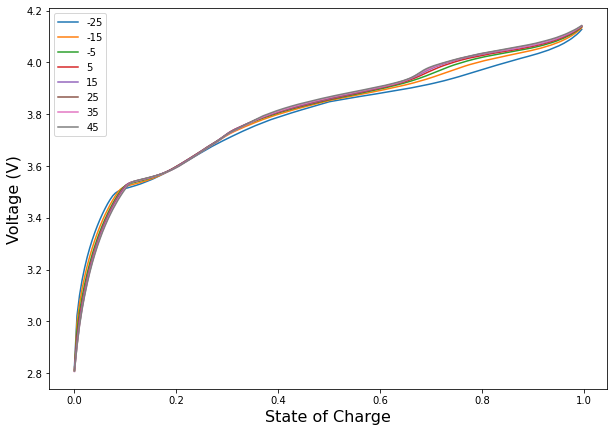

In [226]:
plt.figure(figsize=(10,7))
for t in list(data.keys()):
    plt.plot(data[t]['SOC'],data[t]['rawocv'],label=t)
plt.legend()
plt.ylabel('Voltage (V)',fontsize=16)
plt.xlabel('State of Charge',fontsize=16)

In [323]:
def create_lookup_table(data):

    # Use only data where T > 0C as cold temperate data 
    temps = [x for x in data.keys() if x > 0]
    num_temps = len(temps)
    ocv_size = data[25]['rawocv'].shape[0]

    ocv_arr = np.ones((num_temps,ocv_size))
    temp_arr = np.ones((num_temps,1))

    for ind,temp in enumerate(temps):
        temp_arr[ind] = temp
        ocv_arr[ind] = data[temp]['rawocv']

    temp_arr = np.hstack((np.ones((len(temp_arr),1)),temp_arr)) 

    # Solve linear set of equations, A*x = y
    A = temp_arr
    y = ocv_arr
    
    OCV0, OCVrel = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return OCV0, OCVrel

In [317]:
OCV0, OCVrel = solve_linear_equations(data)

In [320]:
T = -5
OCV_T = OCV0 + T*OCVrel

In [309]:
testSOC = 0.55 #% for example. Change "0.85" to the SOC of interest
testOCV = interp1d(data[5]['SOC'],OCV_T)

In [310]:
testOCV(testSOC)

array(3.8845654)

Text(0.5, 0, 'State of Charge')

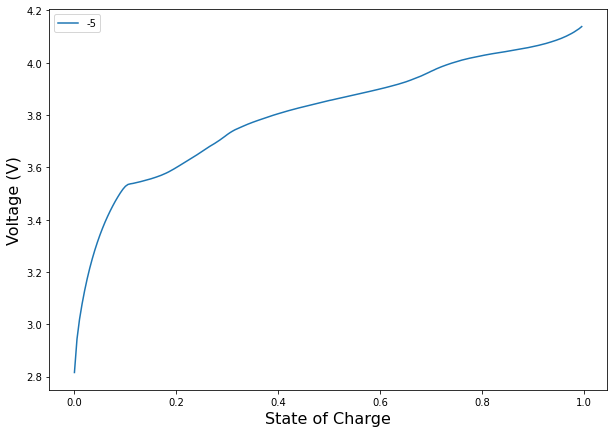

In [321]:
plt.figure(figsize=(10,7))
plt.plot(data[5]['SOC'],OCV_T,label=T)
plt.legend()
plt.ylabel('Voltage (V)',fontsize=16)
plt.xlabel('State of Charge',fontsize=16)